In [1]:
# Импорт библиотек
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt 

In [7]:
snowfall = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv')

df = snowfall.set_index('year number')

,x
year number,
1,126.4
2,82.4
3,78.1
4,51.1
5,90.9
...,...
59,66.1
60,78.4
61,120.5


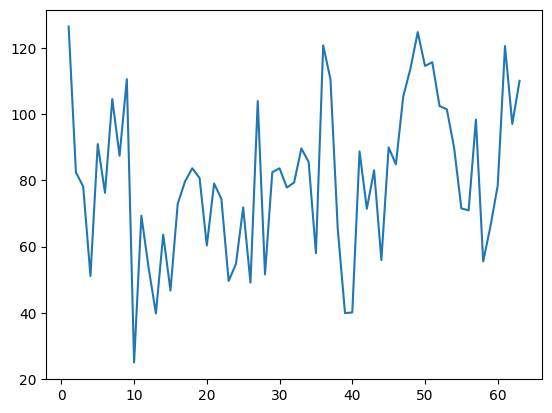

In [12]:
plt.plot(df)

In [13]:
# импортируем функцию, описывающую тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

In [50]:
def stat_check(ts, name):
    alpha = 0.05

    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [51]:
stat_check(df['x'], "Ежегодный снегопад")

Тест Дики-Фуллера ряда Ежегодный снегопад :
Test Statistic                -5.718539e+00
p-value                        7.028398e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [43]:
nottrend = []
s = 6
notseason = []

# выборка без тренда
for i in range(2, len(df["x"]) + 1):
   nottrend.append(df["x"][i] - df["x"][i-1])

# выборка без сезонности
for i in range(s + 1, len(df["x"]) + 1):
   notseason.append(df["x"][i] - df["x"][i-s])


In [52]:
# проверка на стационарность ряда без тренда
stat_check(nottrend, "Ежегодный снегопад без тренда")

Тест Дики-Фуллера ряда Ежегодный снегопад без тренда :
Test Statistic                -6.817940e+00
p-value                        2.036429e-09
#Lags Used                     2.000000e+00
Number of Observations Used    5.900000e+01
Critical Value (1%)           -3.546395e+00
Critical Value (5%)           -2.911939e+00
Critical Value (10%)          -2.593652e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


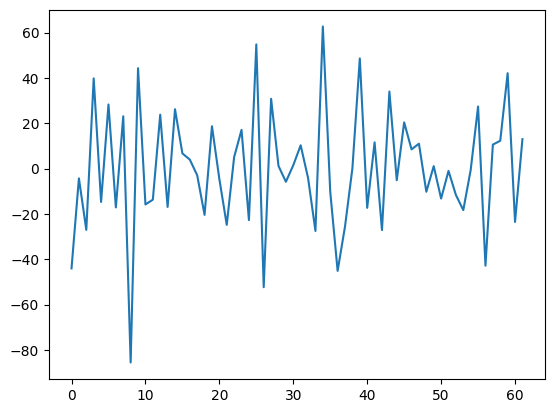

In [53]:
# отрисовываем ряд без тренда
plt.plot(nottrend)

In [54]:
stat_check(notseason, "Ежегодный снегопад без сезонности")

Тест Дики-Фуллера ряда Ежегодный снегопад без сезонности :
Test Statistic                 -3.265229
p-value                         0.016506
#Lags Used                     11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


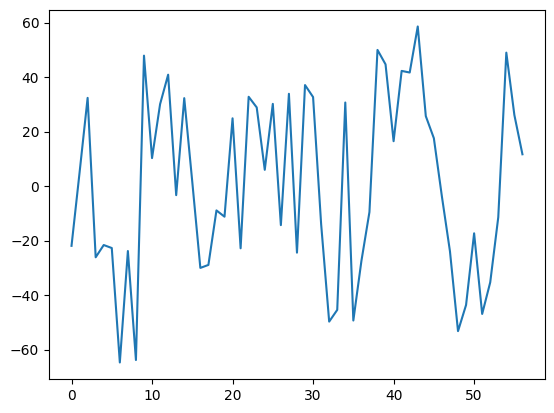

In [55]:
# отрисовываем ряд без сезонности
plt.plot(notseason)

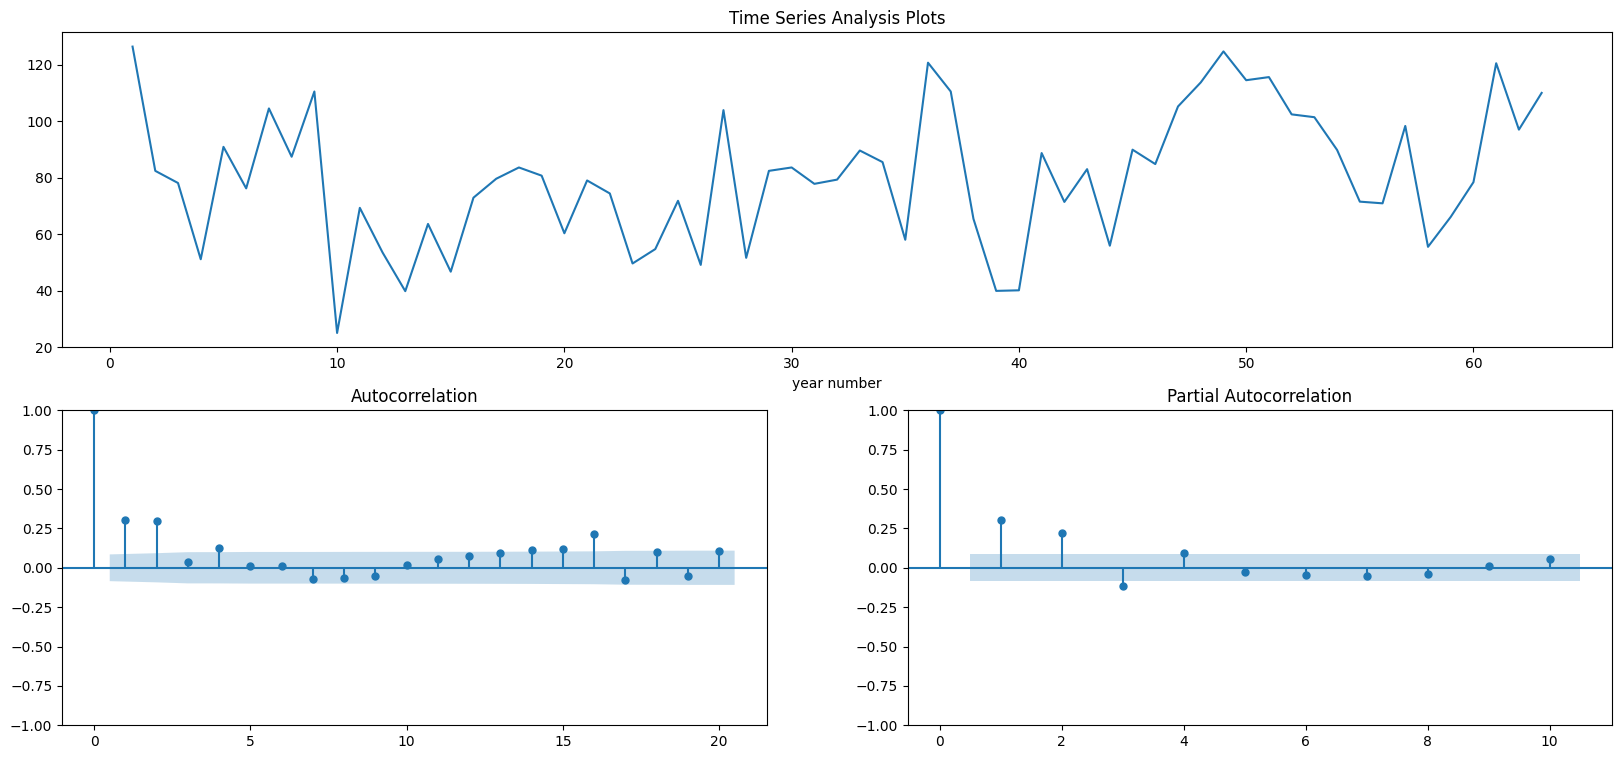

In [56]:
# Автокорреляция, частичная автокорреляция
ts = df['x']

fig = plt.figure(figsize=(20, 9))
layout = (2, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))

ts.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(ts, lags=20, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(ts, lags=10, ax=pacf_ax, alpha=0.5)
None

In [67]:
df = pd.read_csv('data/Annual snowfall in Buffalo 19101972.csv', names=["n","x"], skiprows=1)


df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

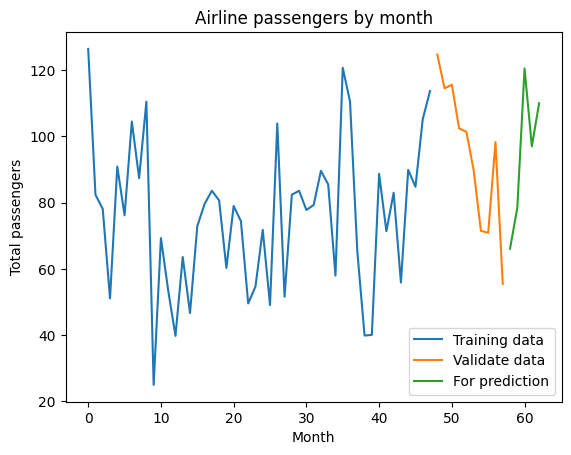

In [75]:
# Визуализируем поделенные выборки.

# * Обучающая выборка - синим цветом
# * Валидационная выборка - оранжевым цветом
# * Предсказываемая выборка - зеленым цветом

plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Airline passengers by month')
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [76]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [77]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(df.t, 3, old_names=False)
# обучаем
res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   63
Model:                     AutoReg(3)   Log Likelihood                1817.553
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 09 Nov 2023   AIC                          -3625.106
Time:                        15:43:31   BIC                          -3614.635
Sample:                             3   HQIC                         -3621.010
                                   63                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   1.45e-15   4.61e+14      0.000       0.667       0.667
t.L1           1.0000   1.41e-15   7.08e+14      0.000       1.000       1.000
t.L2           0.3333   4.13e-17   8.08e+15      0.0

In [78]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      t   No. Observations:                   63
Model:                     AutoReg(3)   Log Likelihood                1817.553
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 09 Nov 2023   AIC                          -3625.106
Time:                        15:43:42   BIC                          -3614.635
Sample:                             3   HQIC                         -3621.010
                                   63                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6667   1.12e-15   5.93e+14      0.000       0.667       0.667
t.L1           1.0000   1.08e-15   9.28e+14      0.000       1.000       1.000
t.L2           0.3333   5.15e-17   6.47e+15      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


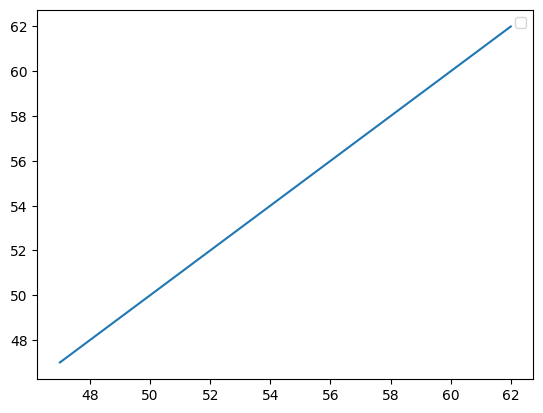

In [79]:
# предсказание
fig = res.plot_predict(train_cutoff)

In [65]:
# предсказанные временные ряды
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)

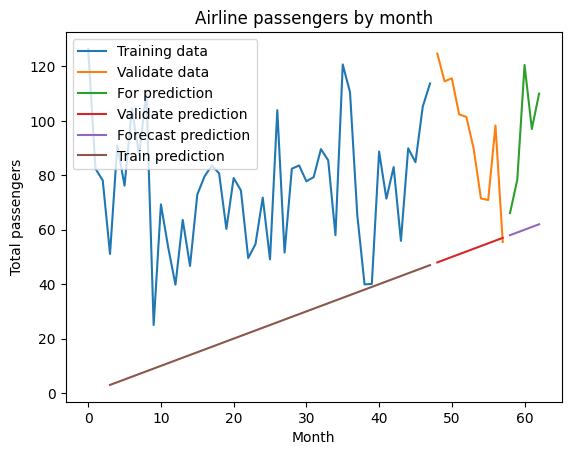

In [66]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.title('Airline passengers by month')
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [81]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score, 

In [87]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
smape = np.mean(np.abs(forecast_df.x - f_pred) / (np.abs(forecast_df.x + f_pred) / 2))
print('SMAPE: ', smape)

RMSE: 39.24849041683002
MAPE: 0.33591258580031413
MAE: 34.39999999999996
R2:  -2.873927432577878
SMAPE:  0.41942458521811476
